In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import sys
import numpy as np
import matplotlib.colors as mcolors
import colorsys

In [2]:
def get_number_of_egdes(path_to_file: str) -> int:
    with open(path_to_file, 'r') as f:
        lines = f.readlines()
        
        for l in lines:
            if l.startswith('FROM'):
                edges = l.replace('FROM', '')   
                edges = edges.strip()
                edges = edges.split(",")
                edges = [e.strip() for e in edges if e.find("edge") > -1]
                edges = [int(e.split(" ")[1].replace("e", "")) for e in edges]
                
                return max(edges) + 1
                

# Loading data

In [3]:
# counting number of edge relation copies in the queries
path_director = "../benchmarks/workloads/subgraph_matching/dblp"
query_files = os.listdir(path_director)
query_files = [f for f in query_files if f.endswith(".sql")]
query_files = [f for f in query_files if f.find("_8_") != -1]
dict_edges = {}

for q in query_files:
    number_edges = get_number_of_egdes(os.path.join(path_director, q))
    dict_edges[q] = number_edges
    
df_edges = pd.DataFrame(dict_edges.items(), columns=["query", "edges"])
df_edges["query"] = df_edges["query"].str.replace(".sql", "")
df_edges.head(2)

,query,edges
0,dblp_query_dense_8_1,15
1,dblp_query_dense_8_10,14


In [4]:
path_results = "../results/accuracy_cyclic"

df_duckdb = pd.read_csv(path_results + "/duckdb_estimates.txt", header=None)
df_duckdb.columns =["query", "DuckDB_estimate"]
print(df_duckdb.head(1))

df_lpbound = pd.read_csv(path_results + "/dblp_undirected_8.log", header=None)
df_lpbound.columns =["query", "LpBoubd_estimate"]
print(df_lpbound.head(1))

df_postgres = pd.read_csv(path_results + "/postgres_estimates.txt", header=None)
df_postgres.columns =["query", "Postgres_estimate"]
print(df_postgres.head(1))

df_dbx = pd.read_csv(path_results + "/dbx_estimates.txt", header=None)
df_dbx.columns =["query", "DBX_estimate"]
print(df_dbx.head(1))

df_true_card = pd.read_csv(path_results + "/true_cards.csv", header=None, sep="|")
df_true_card.columns = ["query", "TrueCard", "runtime", "run", "n_splits", "splitting", "vo"]
df_true_card = df_true_card[["query", "TrueCard"]]
df_true_card.head(1)

                    query  DuckDB_estimate
0  dblp_query_dense_8_100          9604420
                  query  LpBoubd_estimate
0  dblp_query_dense_8_1      1.389949e+09
                    query  Postgres_estimate
0  dblp_query_dense_8_100                  1
                   query  DBX_estimate
0  dblp_query_dense_8_72             1


,query,TrueCard
0,dblp_query_dense_8_1,32742232


In [5]:
df = pd.merge(df_duckdb, df_lpbound, on="query").merge(df_true_card, on="query").merge(df_postgres, on="query")
df["DuckDB"] = df["DuckDB_estimate"] / df["TrueCard"]
df["LpBound"] = df["LpBoubd_estimate"] / df["TrueCard"]
df["Postgres"] = df["Postgres_estimate"] / df["TrueCard"]
df["DBX"] = df_dbx["DBX_estimate"] / df["TrueCard"]

In [6]:
# box plot of LpBound and DuckDB
df_melted = df.melt(id_vars=["query"], value_vars=["LpBound", "DuckDB", "Postgres", "DBX"], var_name="Estimator", value_name="Estimate Error")
df_melted["type"] = df_melted["query"].apply(lambda x: "dense" if x.find("dense") != -1 else "sparse")
df_melted = df_melted.merge(df_edges, on="query")

/tmp/ipykernel_2761775/3143426592.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('Set2')(np.linspace(0, 1, 8))


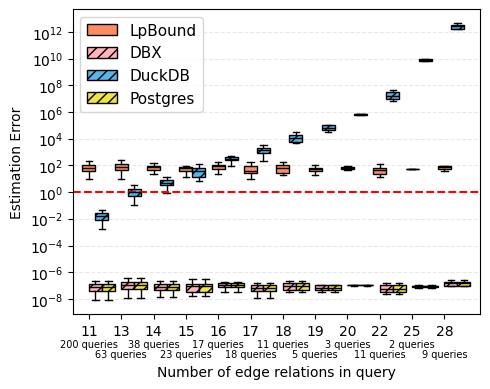

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


estimators = ['LpBound', 'DBX','DuckDB', 'Postgres',]
edges = df_melted.edges.unique()
edges.sort()
color_palette = plt.cm.get_cmap('Set2')(np.linspace(0, 1, 8))

# Color palette
nature_palette = {
    'blue': '#0072B2', 'orange': '#E69F00', 'green': '#009E73', 'red': '#D55E00',
    'purple': '#CC79A7', 'yellow': '#F0E442', 'sky_blue': '#56B4E9', 'pink': '#FFB3BA'
}

ESTIMATOR_COLORS = {
    'LpBound': color_palette[1], 
    'TrueCardinality': nature_palette['blue'],
    'DuckDB': nature_palette['sky_blue'], 'DBX': nature_palette['pink'],
    'Postgres': nature_palette['yellow'], 'FactorJoin': nature_palette['orange'],
}

# Set style
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10

# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Prepare data for boxplot
positions = []
data_to_plot = []
colors = []
for i, edge in enumerate(edges):
    edge_data = df_melted[df_melted['edges'] == edge]
    for j, estimator in enumerate(estimators):
        estimator_data = edge_data[edge_data['Estimator'] == estimator]['Estimate Error']
        if not estimator_data.empty:
            positions.append(i + j * 0.2)
            data_to_plot.append(estimator_data)
            colors.append(ESTIMATOR_COLORS[estimator])

# Create boxplot
bp = ax.boxplot(data_to_plot, positions=positions, widths=0.4, patch_artist=True, 
                showfliers=False, medianprops={'color': 'black'})

# Color boxes and add hatches
hatches = {estimator: '///' if estimator in ['Postgres', 'DuckDB', 'DBX'] else '' for estimator in estimators}
for patch, color, estimator in zip(bp['boxes'], colors, estimators * len(edges)):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_hatch(hatches[estimator])

# Set y-axis to log scale
ax.set_yscale('log')

# Add horizontal line at y=1
ax.axhline(y=1, color='r', linestyle='--', linewidth=1.5)

# Set y-ticks
ax.set_yticks([10**i for i in range(-8, 13, 2)])

# Set x-ticks
ax.set_xticks(range(len(edges)))
ax.set_xticklabels(edges)

# Add number of queries annotation
counts = [200, 63, 38, 23, 17, 18, 11, 5, 3, 11, 2, 9]
alternate_ = 0
for i, count in enumerate(counts):
    ax.text(i, 10**(-11 - alternate_), f"{count} queries", ha='center', va='top', size=7, rotation=0)
    if alternate_ == 0:
        alternate_ = 0.8
    else:
        alternate_ = 0

# Set labels
ax.set_xlabel("\n\nNumber of edge relations in query", fontsize=10, fontweight='normal')
ax.xaxis.set_label_coords(0.5, -0.06)  # Adjust these values to move the label up or down

ax.set_ylabel("Estimation Error", fontsize=10, fontweight='normal')
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgray', alpha=0.5)

# Customize legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=ESTIMATOR_COLORS[e], edgecolor='black', 
                                 label=e, hatch=hatches[e]) for e in estimators]
ax.legend(handles=legend_elements, fontsize='11', loc='upper left')

# Adjust layout
plt.tight_layout()

# export as eps in high resolution
#plt.savefig("error_cardinality_estimation_dblp_8_undirected.eps", format='eps', dpi=800)

# Show plot
plt.show()